In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility imports
from utilities.processing_utility import get_q_2_cw_data 
from utilities.processing_utility import get_train_test_split, get_moving_average

from strategies.ma_mean_reversion import moving_average_mean_reversion_strategy, plot_strategy, cross_validation


In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'S&P 500 adjusted closing price')

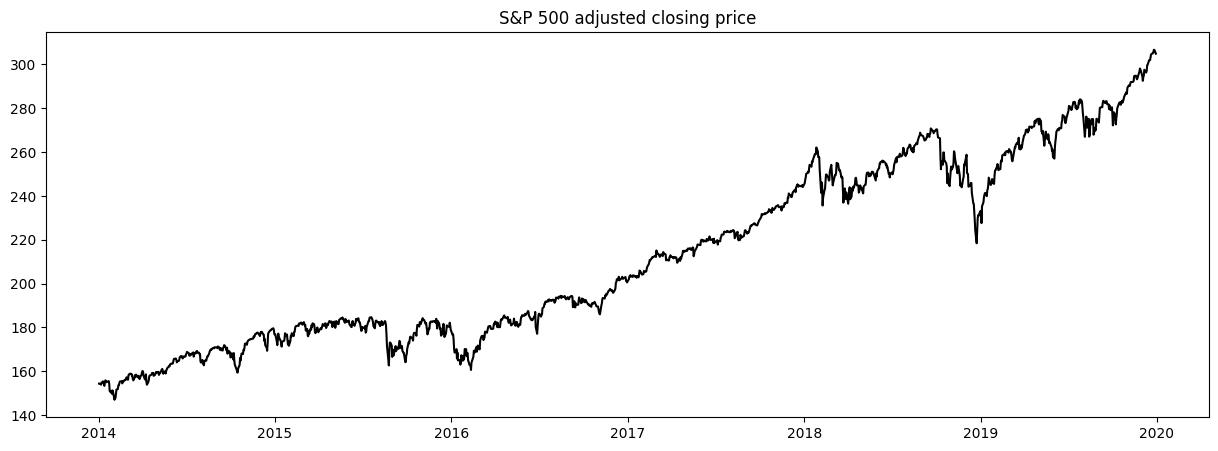

In [3]:
# plot S&P 500
plt.plot(df['adjusted_close_price'], color='black')
plt.title('S&P 500 adjusted closing price')

Text(0.5, 1.0, 'Normalised Excess Returns')

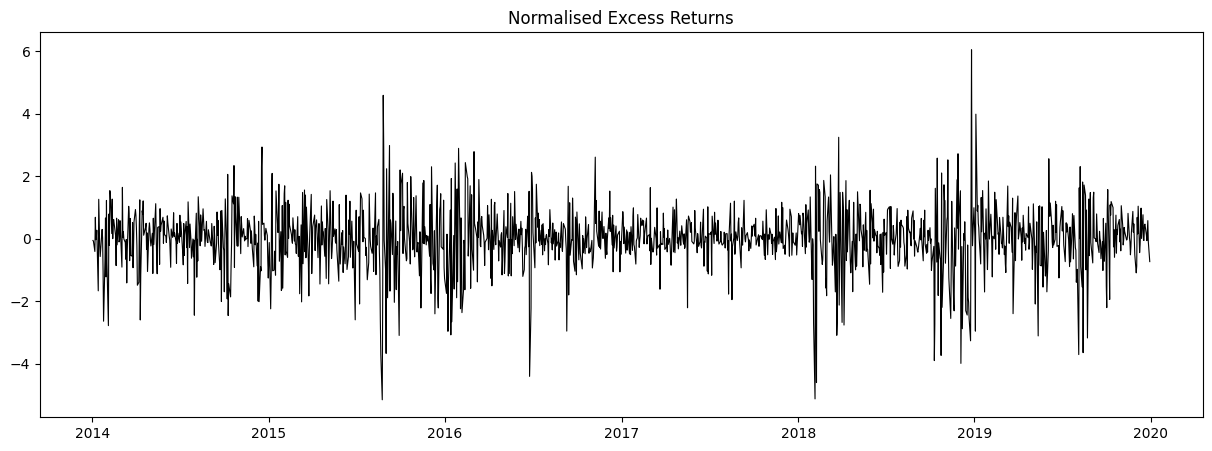

In [4]:
# plot normalised excess returns
plt.plot(df['normalised_excess_returns'], color = 'black', lw = 0.8, alpha = 1)
plt.title('Normalised Excess Returns')

In [5]:
# get train test split
excess_return_data =df['normalised_excess_returns'].to_numpy()
price_data = df['adjusted_close_price'].to_numpy()

r_train, p_train, r_test, p_test = get_train_test_split(
    x_data = excess_return_data,
    y_data = price_data,
    split = 0.7,)

# spint an x_range
_range = np.arange(0, len(price_data))
train_range = _range[:len(r_train)]
test_range = _range[len(r_train):]

Text(0.5, 1.0, 'S&P 500 normalised Excess Returns')

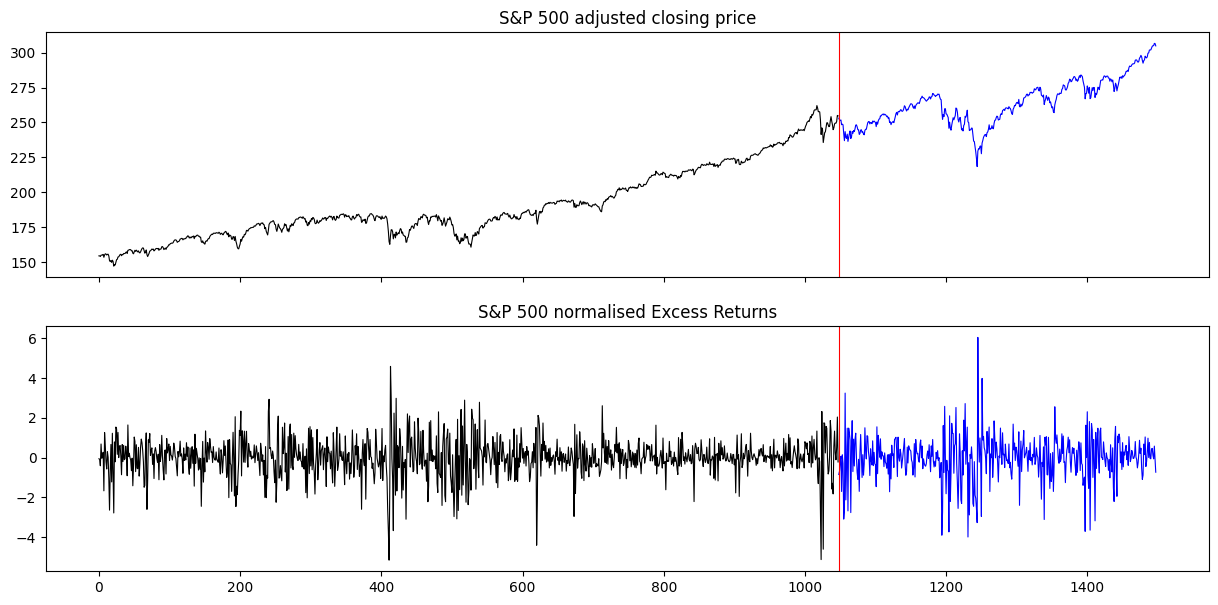

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 7))

# plot the original price series
ax1.plot(train_range, p_train, color = 'black', lw = 0.8, alpha = 1)
ax1.plot(test_range, p_test, color = 'blue', lw = 0.8, alpha = 1)
ax1.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax1.set_title('S&P 500 adjusted closing price')

# plot the normalised excess returns
ax2.plot(train_range, r_train, color = 'black', lw = 0.8, alpha = 1)
ax2.plot(test_range, r_test, color = 'blue', lw = 0.8, alpha = 1)
ax2.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax2.set_title('S&P 500 normalised Excess Returns')

In [7]:
# do a cross validation sweep to find optimal parameters
window_size_sweep = np.arange(5, 55, 5)
boillinger_band_threshold_sweep = np.arange(0, 2.2, 0.2)

window_star, threshold_star = cross_validation(
    normalised_daily_excess_returns = r_train,
    price_series = p_train,
    window_size_sweep = window_size_sweep,
    boillinger_band_threshold_sweep = boillinger_band_threshold_sweep,
    initial_cash =  1.,)

Window Size:        5        | Boillinger Band Threshold:      0.000      | Returns: 1.335938759252757
Window Size:        5        | Boillinger Band Threshold:      0.200      | Returns: 1.3048408975820058
Window Size:        5        | Boillinger Band Threshold:      0.400      | Returns: 1.341493224353864
Window Size:        5        | Boillinger Band Threshold:      0.600      | Returns: 1.381501740319403
Window Size:        5        | Boillinger Band Threshold:      0.800      | Returns: 1.395321662138957
Window Size:        5        | Boillinger Band Threshold:      1.000      | Returns: 1.347151005702659
Window Size:        5        | Boillinger Band Threshold:      1.200      | Returns: 1.3335123195018703
Window Size:        5        | Boillinger Band Threshold:      1.400      | Returns: 1.2655895185577024
Window Size:        5        | Boillinger Band Threshold:      1.600      | Returns: 1.4483305779125075
Window Size:        5        | Boillinger Band Threshold:      1.800 

In [8]:
# print optimal hyperparameters
print(f"Optimal window size: {window_star}")
print(f"Optimal boillinger band threshold: {threshold_star}")

Optimal window size: 10
Optimal boillinger band threshold: 1.4000000000000001


In [14]:
# perform trading strategy on trianing set
mr_train_returns, mr_rain_w, mr_train_cash = moving_average_mean_reversion_strategy(
                                normalised_daily_excess_returns = r_train, 
                                price_series = p_train, 
                                window_size = window_star, 
                                boillinger_band_threshold = 2,
                                initial_cash = 1.)

# perform trading strategy on test set
mr_test_returns, mr_w_test, mr_cash_test = moving_average_mean_reversion_strategy(
                                normalised_daily_excess_returns = r_test,
                                price_series = p_test,
                                window_size = window_star,
                                boillinger_band_threshold = 2,
                                initial_cash = 1.)

Text(0.5, 1.0, 'Moving Average Mean Reversion Strategy Training Set')

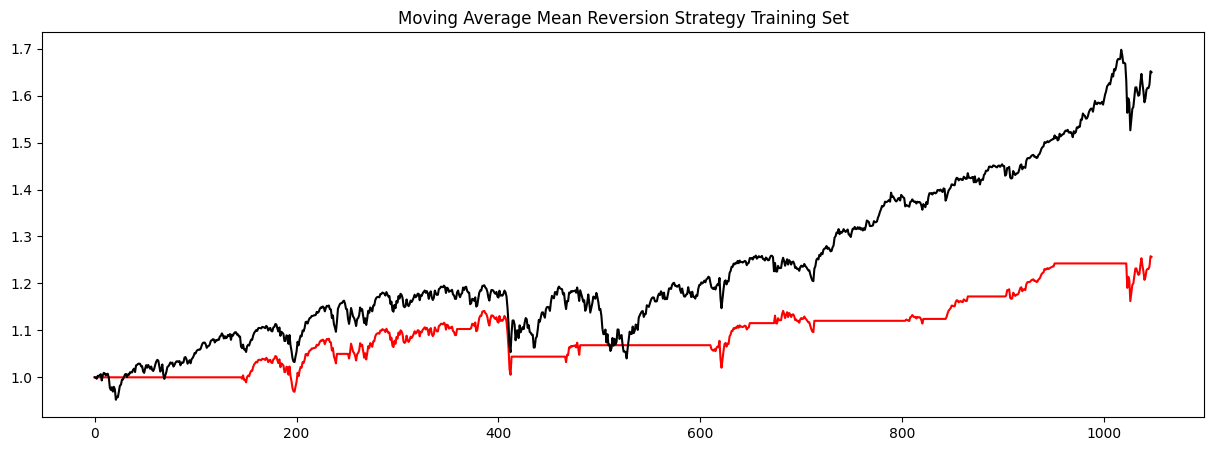

In [15]:
# plot strategy on training set
plt.plot(mr_train_returns, color = 'red')
plt.plot(p_train / p_train[0], color = 'black')
plt.title('Moving Average Mean Reversion Strategy Training Set')

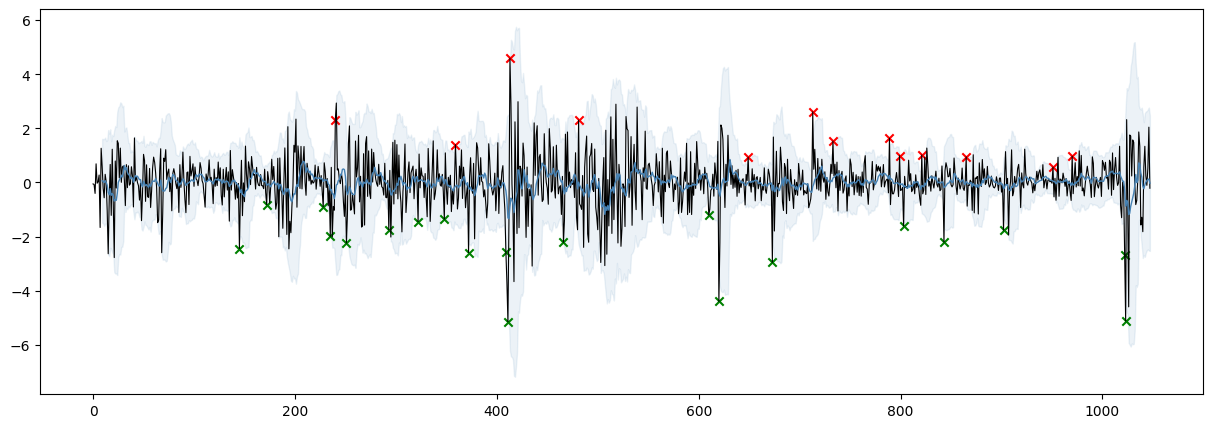

In [17]:
fig, ax = plt.subplots(1, 1)

plot_strategy(
    plot_axis =ax,
    normalised_daily_excess_returns = r_train,
    window_size = window_star,
    boillinger_band_threshold = 2,)

Text(0.5, 1.0, 'Moving Average Mean Reversion Strategy Training Set')

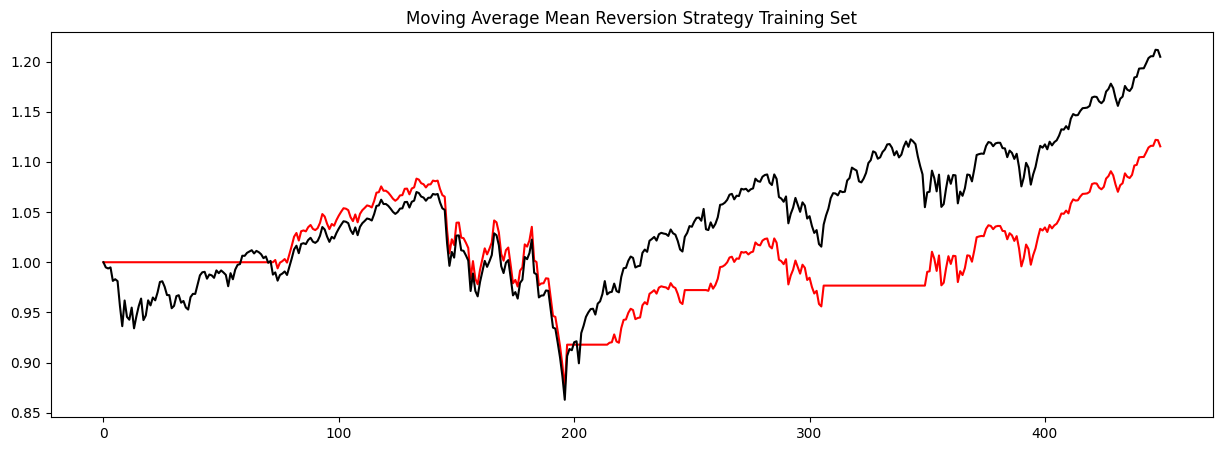

In [18]:
# plot strategy on test set
plt.plot(mr_test_returns, color = 'red')
plt.plot(p_test / p_test[0], color = 'black')
plt.title('Moving Average Mean Reversion Strategy Training Set')

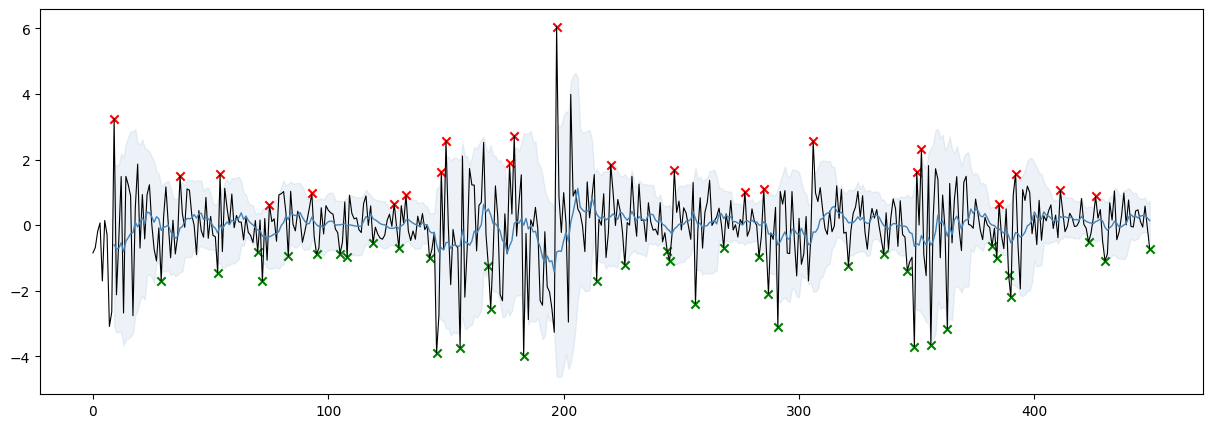

In [19]:
fig, ax = plt.subplots(1, 1)

plot_strategy(
    plot_axis =ax,
    normalised_daily_excess_returns = r_test,
    window_size = window_star,
    boillinger_band_threshold = threshold_star,)